<a href="https://colab.research.google.com/github/MLvtt/Dog-Years-Age-Classification/blob/main/src/SDog_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import tensorflow_datasets as tfds

In [2]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteADLU2P/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteADLU2P/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


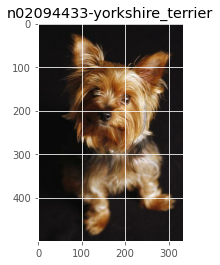

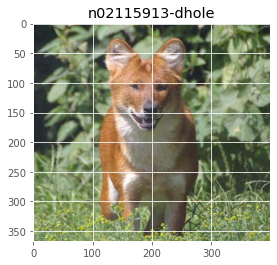

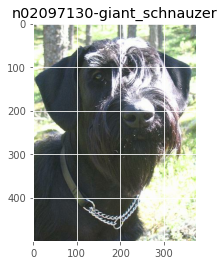

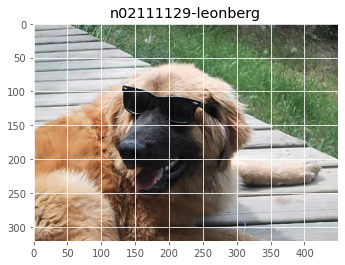

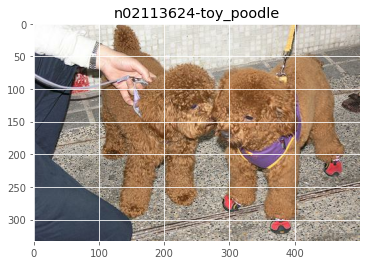

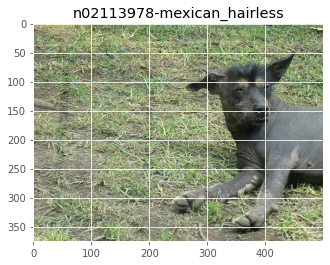

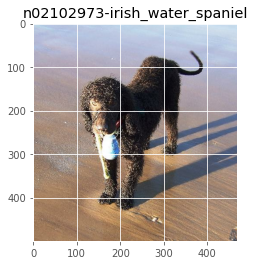

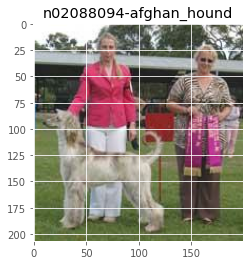

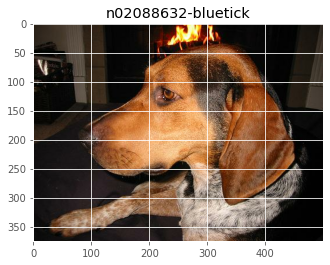

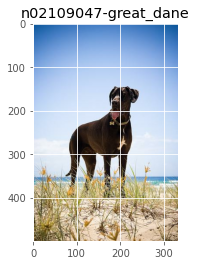

In [3]:
get_name = info.features['label'].int2str

for doggo in dataset['train'].take(10):
    plt.figure()
    plt.imshow(doggo['image'])
    plt.title(get_name(doggo['label']))

In [4]:
IMG_LEN = 224
IMG_SHAPE = (IMG_LEN,IMG_LEN,3)
N_BREEDS = 120

training_data = dataset['train']
test_data = dataset['test']

def preprocess(ds_row):
  
    # Image conversion int->float + resizing
    image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
    image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
  
    # Onehot encoding labels
    label = tf.one_hot(ds_row['label'],N_BREEDS)

    return image, label

def prepare(dataset, batch_size=None):
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet', classes=120)
# base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet', classes=120)
# base_model = tf.keras.applications.(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet', classes=120)
base_model.output_shape

9412608/9406464 [==============================] - 0s 0us/step


(None, 7, 7, 1280)

In [8]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1000, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(N_BREEDS, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1281000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               120120    
Total params: 3,659,104
Trainable params: 1,401,120
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
			  
train_batches = prepare(training_data, batch_size=32)
test_batches = prepare(test_data, batch_size=32)

early_stop = EarlyStopping(monitor='loss', patience=3)

mdl_check = ModelCheckpoint(filepath='models/best_model.hdf5',
                            save_best_only=True)

history = model.fit(train_batches,
                    epochs=50,
                    validation_data=test_batches,
                    callbacks=[mdl_check, early_stop])

Epoch 1/50
375/375 [==============================] - 131s 339ms/step - loss: 4.2853 - accuracy: 0.1020 - top_k_categorical_accuracy: 0.2732 - val_loss: 3.4462 - val_accuracy: 0.4339 - val_top_k_categorical_accuracy: 0.7666


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
375/375 [==============================] - 128s 339ms/step - loss: 3.0925 - accuracy: 0.3478 - top_k_categorical_accuracy: 0.6746 - val_loss: 2.3614 - val_accuracy: 0.6147 - val_top_k_categorical_accuracy: 0.8979
Epoch 3/50
375/375 [==============================] - 133s 351ms/step - loss: 2.2986 - accuracy: 0.4742 - top_k_categorical_accuracy: 0.8074 - val_loss: 1.7206 - val_accuracy: 0.6865 - val_top_k_categorical_accuracy: 0.9280
Epoch 4/50
375/375 [==============================] - 129s 343ms/step - loss: 1.8375 - accuracy: 0.5559 - top_k_categorical_accuracy: 0.8653 - val_loss: 1.3944 - val_accuracy: 0.7115 - val_top_k_categorical_accuracy: 0.9390
Epoch 5/50
375/375 [==============================] - 129s 341ms/step - loss: 1.5469 - accuracy: 0.6083 - top_k_categorical_accuracy: 0.8974 - val_loss: 1.2144 - val_accuracy: 0.7283 - val_top_k_categorical_accuracy: 0.9420
Epoch 6/50
375/375 [==============================] - 129s 341ms/step - loss: 1.3672 - accuracy: 0.6438 

In [10]:
filename = '/content/finalized_model_sdog.h5'
model.save(filename)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


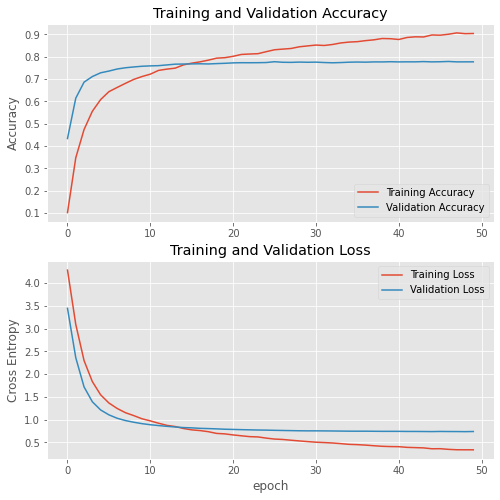

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [18]:
yanna = load_img('/content/IMG-20190929-153602.jpg', target_size=(224, 224))
yanna = img_to_array(yanna) * 1./255
yanna = np.expand_dims(yanna, axis=0)
yanna.shape

(1, 224, 224, 3)

In [19]:
np.expand_dims(yanna, axis=0)

array([[[[[0.3254902 , 0.23529412, 0.10196079],
          [0.3254902 , 0.23529412, 0.10196079],
          [0.33333334, 0.24313726, 0.10980392],
          ...,
          [0.59607846, 0.7607843 , 0.91764706],
          [0.59607846, 0.7490196 , 0.9098039 ],
          [0.59607846, 0.7490196 , 0.9019608 ]],

         [[0.3254902 , 0.23529412, 0.10196079],
          [0.3254902 , 0.23529412, 0.10196079],
          [0.33333334, 0.24313726, 0.10980392],
          ...,
          [0.59607846, 0.7607843 , 0.91764706],
          [0.59607846, 0.7490196 , 0.9098039 ],
          [0.59607846, 0.7490196 , 0.9019608 ]],

         [[0.32941177, 0.23921569, 0.10588235],
          [0.32941177, 0.23921569, 0.10588235],
          [0.32941177, 0.23921569, 0.10588235],
          ...,
          [0.59607846, 0.7607843 , 0.91764706],
          [0.59607846, 0.7490196 , 0.9098039 ],
          [0.59607846, 0.7490196 , 0.9019608 ]],

         ...,

         [[0.6039216 , 0.4       , 0.07450981],
          [0.5529412 ,

In [20]:
arg = np.argsort(model.predict(yanna), axis=-1)[0][:-6:-1]

In [21]:
pct = np.sort(model.predict(yanna), axis=-1)[0][:-6:-1]

In [25]:
get_name()

TypeError: ignored

In [22]:
# (model.predict(yanna)[0])
model.predict?

In [23]:
for a, p in zip(arg, pct):
  print(get_name(a), round(p*100,2))

n02093428-american_staffordshire_terrier 84.87
n02093256-staffordshire_bullterrier 6.06
n02089973-english_foxhound 1.12
n02113186-cardigan 0.94
n02087046-toy_terrier 0.78


In [ ]:
! unzip /content/drive/MyDrive/data/Expert_Train.zip
! unzip /content/drive/MyDrive/data/PetFinder_All.zip

In [ ]:
!pip install split_folders
import splitfolders
splitfolders.ratio('/content/Expert_TrainEval', output='/content/Combo_Dataset', seed=1337, ratio=(.8, 0.15,0.05))
splitfolders.ratio('/content/PetFinder_All', output='/content/Combo_Dataset', seed=1337, ratio=(.8, 0.15,0.05))

Copying files: 1088 files [00:00, 2823.93 files/s]
Copying files: 26190 files [00:06, 4300.44 files/s]


In [ ]:
img_width = 224
img_height = 224
batch_size = 16
 
# this is the augmentation configuration we will use for training
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
# this is the augmentation configuration we will use for testing:
# only rescaling (we do not want to modify the testing data)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
 
 
# The generator object. 
train_generator = train_datagen.flow_from_directory(
    '/content/Combo_Dataset/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')
 
validation_generator = test_datagen.flow_from_directory(
    '/content/Combo_Dataset/val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 21821 images belonging to 3 classes.
Found 4089 images belonging to 3 classes.


In [ ]:
data_gen = keras.preprocessing.image.ImageDataGenerator( rescale=1. / 255)
data_generator = train_datagen.flow_from_directory('/content/Expert_TrainEval',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')



In [ ]:
base_model = keras.models.load_model('/content/models/best_model.hdf5')

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(3, activation='softmax')
])
 
model.compile(optimizer=tf.keras.optimizers.Adamax(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

ValueError: ignored

In [52]:
info.features['label'].int2str(119).split('-',1)[-1].title()

'African_Hunting_Dog'

In [42]:
import pickle

In [53]:
SDog_Classes = {}
for i in range(120):
  SDog_Classes[i] = info.features['label'].int2str(i).split('-',1)[-1].title()

In [57]:
with open('sdog_classes.pkl', 'wb') as f:
  pickle.dump(SDog_Classes, f)
# SDog_Classes

In [58]:
SDog_Classes

{0: 'Chihuahua',
 1: 'Japanese_Spaniel',
 2: 'Maltese_Dog',
 3: 'Pekinese',
 4: 'Shih-Tzu',
 5: 'Blenheim_Spaniel',
 6: 'Papillon',
 7: 'Toy_Terrier',
 8: 'Rhodesian_Ridgeback',
 9: 'Afghan_Hound',
 10: 'Basset',
 11: 'Beagle',
 12: 'Bloodhound',
 13: 'Bluetick',
 14: 'Black-And-Tan_Coonhound',
 15: 'Walker_Hound',
 16: 'English_Foxhound',
 17: 'Redbone',
 18: 'Borzoi',
 19: 'Irish_Wolfhound',
 20: 'Italian_Greyhound',
 21: 'Whippet',
 22: 'Ibizan_Hound',
 23: 'Norwegian_Elkhound',
 24: 'Otterhound',
 25: 'Saluki',
 26: 'Scottish_Deerhound',
 27: 'Weimaraner',
 28: 'Staffordshire_Bullterrier',
 29: 'American_Staffordshire_Terrier',
 30: 'Bedlington_Terrier',
 31: 'Border_Terrier',
 32: 'Kerry_Blue_Terrier',
 33: 'Irish_Terrier',
 34: 'Norfolk_Terrier',
 35: 'Norwich_Terrier',
 36: 'Yorkshire_Terrier',
 37: 'Wire-Haired_Fox_Terrier',
 38: 'Lakeland_Terrier',
 39: 'Sealyham_Terrier',
 40: 'Airedale',
 41: 'Cairn',
 42: 'Australian_Terrier',
 43: 'Dandie_Dinmont',
 44: 'Boston_Bull',
 45: